In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

### Implementing classes and real network

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_data():
    """
    data : (10 000 x 3072)
    labels : (10 000 x 1)
    one_hot : (10 000 x 10)
    """
    
    file = unpickle("data/cifar-10-batches-py/data_batch_1")
    labels = file[b'labels']
    data = file[b'data']
    no_classes = 10
    N = len(labels)
    
    one_hot = np.zeros((N, no_classes))
    one_hot[np.arange(N), labels] = 1
    
    labels = np.array(labels).reshape(-1,1)
    
    # normalize
    mean = np.mean(data, axis=0, keepdims=True)
    std = np.std(data, axis=0, keepdims=True)
    
    X = (data - mean) / std
    return X, labels, one_hot, mean, std

def ReLU(x):
    return np.where(x > 0, x, 0)

def dReLU(x):
    return np.where(x > 0, 1, 0)

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def plot_image(x, mean, std):
    x = (x.T * std + mean).astype(int)
    img = x.reshape(3,32,32)
    plt.figure(figsize=(2,2))
    plt.imshow(np.transpose(img, (1,2,0)))

def check_if_correct(y, p):
    temp = np.argmax(y, axis=1) - np.argmax(p.T, axis=1)
    correct_ones = np.where(temp == 0, 1, 0)
    return np.sum(correct_ones)

class Plotter:
    def __init__(self, title):
        self.title = title
        self.x = []
        self.y = []
        
    def add(self, epoch, cost):
        self.y.append(cost)
        self.x.append(epoch)
    
    def plot(self):
        fig, ax = plt.subplots()
        ax.plot(self.x, self.y)

        ax.set(xlabel="epochs", ylabel="cost", title=self.title)
        ax.grid()
        # fig.savefig("{}.png".format(self.title))
        plt.show()


epoch: 0 	loss: 2.21 	acc: 17.4
epoch: 10 	loss: 1.64 	acc: 40.2
epoch: 20 	loss: 1.23 	acc: 57.1
epoch: 30 	loss: 0.92 	acc: 68.1
epoch: 40 	loss: 0.722 	acc: 75.8
epoch: 50 	loss: 0.569 	acc: 81.2
epoch: 60 	loss: 0.463 	acc: 84.8
epoch: 70 	loss: 0.357 	acc: 88.9
epoch: 80 	loss: 0.275 	acc: 91.9
epoch: 90 	loss: 0.242 	acc: 92.7
epoch: 100 	loss: 0.181 	acc: 94.8
epoch: 110 	loss: 0.141 	acc: 96.4
epoch: 120 	loss: 0.116 	acc: 97.3
epoch: 130 	loss: 0.126 	acc: 96.6
epoch: 140 	loss: 0.0803 	acc: 98.2
epoch: 150 	loss: 0.239 	acc: 92.3
epoch: 160 	loss: 0.0285 	acc: 99.7
epoch: 170 	loss: 0.0189 	acc: 99.8
epoch: 180 	loss: 0.0144 	acc: 99.8
epoch: 190 	loss: 0.108 	acc: 96.9
85.6 s


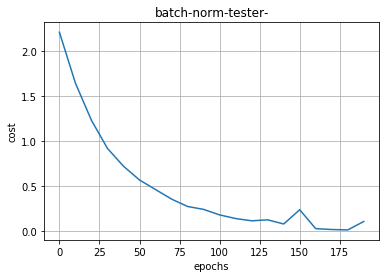

In [14]:
np.random.seed(40)

def train():
    plotter = Plotter("batch-norm-tester-".format(time.time()))
    data, labels, one_hots, mean, std = load_data()
    data_size = data.shape[0]
    lr = 0.05
    w_decay = 0
    no_hidden_1 = 50
    no_hidden_2 = 30
    output_nodes = 10
    
    W1 = np.random.rand(no_hidden_1, 3072) * 0.0001
    W2 = np.random.rand(no_hidden_2, no_hidden_1) * 0.0001
    W3 = np.random.rand(output_nodes, no_hidden_2) * 0.0001
    
    b1 = np.zeros((no_hidden_1, 1))
    b2 = np.zeros((no_hidden_2, 1))
    b3 = np.zeros((output_nodes, 1))
        
    gamma1 = np.random.rand(no_hidden_1, 1)
    beta1 = np.zeros((no_hidden_1, 1))
    
    gamma2 = np.random.rand(no_hidden_2, 1)
    beta2 = np.zeros((no_hidden_2, 1))
    
    batch_size = 100
    iterations = data_size // batch_size
    start_t = time.time()

    for epoch in range(200):
        avg_loss = 0
        accuracy = 0
        
        for idx in range(iterations):
            start = batch_size * idx
            end = batch_size * (idx + 1)

            # get X and Y
            X0 = data[start:end,:].T # 3072x100
            one_hot = one_hots[start:end,:] # 100x10
            
            # Layer 1 with batch_norm
            S1 = np.dot(W1, X0) + b1
            mu_1 = np.sum(S1, axis=1).reshape(-1,1) / batch_size
            var_1 = np.var(S1, axis=1)
            
            S1_hat = np.dot(np.diag( (var_1 + 1e-15) ** (-0.5) ), (S1 - mu_1)) # batchNorm
            S1_t = gamma1 * S1_hat + beta1
            
            X1 = ReLU(S1_t)
            
            # Layer 2 with batch_norm
            S2 = np.dot(W2, X1) + b2
            mu_2 = np.sum(S2, axis=1).reshape(-1,1) / batch_size
            var_2 = np.var(S2, axis=1)
            
            S2_hat = np.dot(np.diag( (var_2 + 1e-15) ** (-0.5) ), (S2 - mu_2))
            S2_t = gamma2 * S2_hat + beta2
            
            X2 = ReLU(S2_t)
            
            # Layer 2 (last layer)
            S3 = np.dot(W3, X2) + b3
            X3 = softmax(S3) 
        
            # LOG LOSS
            L2 = np.sum(W1 ** 2) + np.sum(W2 ** 2) + np.sum(W3 ** 2)
            loss = -np.sum(one_hot * np.log(1e-15 + X3.T)) + w_decay * L2

            avg_loss += (loss / batch_size)
            accuracy += check_if_correct(one_hot, X3)
            
            # print("forward done")
            # backward
            
            # dS2
            G = X3 - one_hot.T # change X here
            
            dW3 = np.dot(G, X2.T) / batch_size
            dW3 += 2 * w_decay * W3
            db3 = np.sum(G, axis=1).reshape(-1,1) / batch_size
            
            # BatchNormBackPass Layer 2
            G = np.dot(W3.T, G) * dReLU(X2) # dX2
            dgamma2 = np.sum(G * S2_hat, axis=1, keepdims=True) / batch_size
            dbeta2 = np.sum(G, axis=1, keepdims=True) / batch_size
            
            G = G * gamma2
            sigma = var_2.reshape(-1,1) + 1e-15
            sigma1 = sigma ** -0.5
            sigma2 = sigma ** -1.5
            
            G1 = G * sigma1
            G2 = G * sigma2
            
            D = S2 - mu_2
            c = np.sum(G2 * D, axis=1, keepdims=True)
            part1 = (1 / batch_size) * (G1 @ np.ones((batch_size, 1))) @ np.ones((1, batch_size))
            part2 = (1 / batch_size) * D * (c @ np.ones((1, batch_size)))
            
            G = G1 - part1 - part2 # dS2
            dW2 = np.dot(G, X1.T) / batch_size
            dW2 += w_decay * 2 * W2
            
            db2 = np.sum(G, axis=1).reshape(-1,1) / batch_size
        
            
            # BatchNormBackPass Layer 1
            G = np.dot(W2.T, G)
            G = G * dReLU(X1) # dX1
            
            dgamma1 = np.sum(G * S1_hat, axis=1, keepdims=True) / batch_size
            dbeta1 = np.sum(G, axis=1, keepdims=True) / batch_size
            
            G = G * gamma1
            
            # == BatchNormBackPass ==
            sigma = var_1.reshape(-1,1) + 1e-15
            sigma1 = sigma ** -0.5
            sigma2 = sigma ** -1.5
            
            G1 = G * sigma1
            G2 = G * sigma2
            
            D = S1 - mu_1
            c = np.sum(G2 * D,axis=1, keepdims=True) # 50x1 osäker
            
            part1 = (1 / batch_size) * (G1 @ np.ones((batch_size, 1))) @ np.ones((1, batch_size))
            part2 = (1 / batch_size) * D * (c @ np.ones((1, batch_size)))
            
            G = G1 - part1 - part2
            # ==========================
            # G = dS1
            
            dW1 = np.dot(G, X0.T) / batch_size
            dW1 += w_decay * 2 * W1
            
            db1 = np.sum(G, axis=1).reshape(-1,1) / batch_size
            
            # update
            W1 = W1 - lr * dW1
            b1 = b1 - lr * db1
            W2 = W2 - lr * dW2
            b2 = b2 - lr * db2
            W3 = W3 - lr * dW3
            b3 = b3 - lr * db3
            
            gamma1 = gamma1 - lr * dgamma1
            beta1 = beta1 - lr * dbeta1
            
            gamma2 = gamma2 - lr * dgamma2
            beta2 = beta2 - lr * dbeta2

        avg_loss /= iterations
        accuracy /= iterations
    
        if (epoch % 10 == 0):
            plotter.add(epoch, avg_loss)
            print("epoch: {} \tloss: {:.3} \tacc: {:.3}".format(epoch, avg_loss, accuracy))

    print("{:.3} s".format(time.time() - start_t))
    plotter.plot()
    
    # print(b1, "\n", b2)

train()